# Implementing RNNs for sequence modeling in TensorFlow
Project one: predicting the sentiment of IMDb movie reviews

Preparing the movie review data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv('sTrain.csv')#('https://raw.githubusercontent.com/tleitch/BDML/main/NLP/sTrain.csv')
df = df.drop(df.columns[[0]],axis=1)
df.tail()

,review,sentiment
30362,We arrived late at night and walked in to a ch...,1
30363,The only positive impression is location and p...,0
30364,Traveling with friends for shopping and a show...,0
30365,The experience was just ok. We paid extra for ...,0
30366,The Westin is a wonderfully restored grande da...,1


In [52]:
df_test=pd.read_csv('sTest.csv')
df_test = df_test.drop(df_test.columns[[0]],axis=1)
df_test.tail()

,review,sentiment
8560,Location superb and rooms (almost uniquely in ...,1
8561,I had reservations for --------- and “STAR”the...,0
8562,then a great place to stay is this hotel. Not ...,1
8563,pretty cool hotel. stayed for a few days in mi...,1
8564,This hotel has a great location if you want to...,0


In [4]:
# Step 1: Create a dataset

target = df.pop('sentiment')

ds_raw = tf.data.Dataset.from_tensor_slices(
    (df.values, target.values))

## inspection:
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50], ex[1])

b'The room was kind of clean but had a VERY strong s' 0
b'I booked this hotel through Hotwire at the lowest ' 0
b'Stayed here with husband and sons on the way to an' 1


In [53]:
#test
target_t = df_test.pop('sentiment')
te_raw = tf.data.Dataset.from_tensor_slices(
    (df_test.values, target_t.values))

In [54]:
tf.random.set_seed(1)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

### .Encoding sequences

In [6]:
## Step 2: find unique tokens (words)

from collections import Counter

tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()

for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0])
    token_counts.update(tokens)
    
print('Vocab-size:', len(token_counts))

Vocab-size: 22798


In [8]:
## Step 3: encoding each unique token into integers

encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)

example_str = 'This is an example!'
encoder.encode(example_str)

[105, 63, 33, 1374]

In [9]:
## Step 3-A: define the function for transformation

def encode(text_tensor, label):
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text, label

## Step 3-B: wrap the encode function to a TF Op.
def encode_map_fn(text, label):
    return tf.py_function(encode, inp=[text, label], 
                          Tout=(tf.int64, tf.int64))

In [63]:
#############train#############
ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
#############test#############
ds_test = ds_raw_test.map(encode_map_fn)
test = te_raw.map(encode_map_fn)
tf.random.set_seed(1)
for example in ds_train.shuffle(1000).take(5):
    print('Sequence length:', example[0].shape)
    
example

Sequence length: (454,)
Sequence length: (137,)
Sequence length: (103,)
Sequence length: (269,)
Sequence length: (63,)


(<tf.Tensor: shape=(63,), dtype=int64, numpy=
 array([ 213,   57,  193,  450,  468,   17, 1522,  114,  467,  976, 1392,
          37,  728,   40,  375,   38, 1012, 8786, 7124,    6, 1139,  647,
        5808,   17, 3759,  204, 8787,  323,  997, 1634,  717, 1655,   17,
        8154,   41,  757, 1996,  998,  682, 5456,   11,  452, 8788,   17,
        3281,   21, 5426,  730,  248,   17, 1589,   65,   57, 1637, 7682,
         938,   17,  939, 8789,  831,  262,  145,  287], dtype=int64)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [12]:
## Take a small subset

ds_subset = ds_train.take(8)
for example in ds_subset:
    print('Individual size:', example[0].shape)

## batching the datasets
ds_batched = ds_subset.padded_batch(
    4, padded_shapes=([-1], []))

for batch in ds_batched:
    print('Batch dimension:', batch[0].shape)

Individual size: (303,)
Individual size: (291,)
Individual size: (92,)
Individual size: (316,)
Individual size: (232,)
Individual size: (132,)
Individual size: (219,)
Individual size: (121,)
Batch dimension: (4, 316)
Batch dimension: (4, 232)


In [55]:
## batching the datasets
##############train#####################
train_data = ds_train.padded_batch(
    32, padded_shapes=([-1],[]))

valid_data = ds_valid.padded_batch(
    32, padded_shapes=([-1],[]))

test_data = ds_test.padded_batch(
    32, padded_shapes=([-1],[]))
##############test#####################
test_f = test.padded_batch(
    32, padded_shapes=([-1],[]))

# Building an RNN model

In [80]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

## lstm

In [37]:
#1 layers LSTM
model_lstm = Sequential()
model_lstm.add(Embedding(100000, 32))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(1))
model_lstm.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 32)          3200000   
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 3,208,353
Trainable params: 3,208,353
Non-trainable params: 0
_________________________________________________________________


## gru  layer=1

In [40]:
##1 layers GRU
model_g1 = Sequential()
model_g1.add(Embedding(100000, 32))
model_g1.add(GRU(32))
model_g1.add(Dense(1))
model_g1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 32)          3200000   
_________________________________________________________________
gru_7 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 3,206,369
Trainable params: 3,206,369
Non-trainable params: 0
_________________________________________________________________


# #gru  layer=2

In [41]:
## 2 layers GRU
model_g2 = Sequential()
model_g2.add(Embedding(100000, 32))
model_g2.add(GRU(32, return_sequences=True))
model_g2.add(GRU(32))
model_g2.add(Dense(1))
model_g2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 32)          3200000   
_________________________________________________________________
gru_8 (GRU)                  (None, None, 32)          6336      
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 3,212,705
Trainable params: 3,212,705
Non-trainable params: 0
_________________________________________________________________


## lstm gru

In [43]:
## An example of building a RNN model
## with LSTM gru layer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
dim1=10
dim2=16
model_lg= Sequential()
model_lg.add(Embedding(100000 ,32))
model_lg.add(LSTM(32, return_sequences=True,input_shape=(dim1,dim2)))
################GRU 1 layer =16################
model_lg.add(GRU(16,return_sequences=True))
model_lg.add(GRU(32))
model_lg.add(Dense(1))
model_lg.summary() 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 32)          3200000   
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 32)          8320      
_________________________________________________________________
gru_10 (GRU)                 (None, None, 16)          2400      
_________________________________________________________________
gru_11 (GRU)                 (None, 32)                4800      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,215,553
Trainable params: 3,215,553
Non-trainable params: 0
_________________________________________________________________


## train lstm

In [38]:
model_lstm.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_lstm.fit(train_data, epochs=2)

Epoch 1/2
168/168 [==============================] - 61s 348ms/step - loss: 0.6924 - accuracy: 0.6484
Epoch 2/2
168/168 [==============================] - 59s 349ms/step - loss: 0.6250 - accuracy: 0.6847


## train gru  layer=1

In [44]:
model_g1.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g1.fit(train_data, epochs=2)

Epoch 1/2
168/168 [==============================] - 61s 353ms/step - loss: 0.7371 - accuracy: 0.6039
Epoch 2/2
168/168 [==============================] - 42s 248ms/step - loss: 0.6240 - accuracy: 0.6816


## train gru  layer=2

In [45]:
model_g2.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g2.fit(train_data, epochs=2)

Epoch 1/2
168/168 [==============================] - 104s 594ms/step - loss: 10.4586 - accuracy: 0.3220
Epoch 2/2
168/168 [==============================] - 110s 656ms/step - loss: 10.4586 - accuracy: 0.3220


## train lstm-gru +epoch=6

In [72]:
model_lg.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_lg.fit(train_data, epochs=6)

Epoch 1/6
168/168 [==============================] - 162s 943ms/step - loss: 5.6484 - accuracy: 0.6328
Epoch 2/6
168/168 [==============================] - 154s 920ms/step - loss: 5.6484 - accuracy: 0.6328
Epoch 3/6
168/168 [==============================] - 159s 945ms/step - loss: 5.6484 - accuracy: 0.6328
Epoch 4/6
168/168 [==============================] - 143s 849ms/step - loss: 5.6484 - accuracy: 0.6328
Epoch 5/6
168/168 [==============================] - 159s 945ms/step - loss: 5.6484 - accuracy: 0.6328
Epoch 6/6
168/168 [==============================] - 157s 933ms/step - loss: 5.6484 - accuracy: 0.6328


# results

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr=[]
tpr=[]
auc=[]
y11=model_lstm.predict(test_f)
yy1=[np.mean(y11[x]) for x in range(y11.shape[0])]
fpr1, tpr1, thresholds = roc_curve(target_t, yy1)
fpr.append(fpr1) 
tpr.append(tpr1) 
auc.append(roc_auc_score(target_t, yy1)) 

y12=model_g1.predict(test_f)
yy2=[np.mean(y12[x]) for x in range(y12.shape[0])]
fpr2, tpr2, thresholds = roc_curve(target_t, yy2)
fpr.append(fpr2) 
tpr.append(tpr2) 
auc.append(roc_auc_score(target_t, yy2)) 

y13=model_g2.predict(test_f)
yy3=[np.mean(y13[x]) for x in range(y13.shape[0])]
fpr3, tpr3, thresholds = roc_curve(target_t, yy3)
fpr.append(fpr3) 
tpr.append(tpr3) 
auc.append(roc_auc_score(target_t, yy3))

y14=model_lg.predict(test_f)
yy4=[np.mean(y14[x]) for x in range(y14.shape[0])]
fpr4, tpr4, thresholds = roc_curve(target_t, yy4)
fpr.append(fpr4) 
tpr.append(tpr4) 
auc.append(roc_auc_score(target_t, yy4))

## gru 1+epoch=10

In [74]:
model_g1.compile(loss="binary_crossentropy",optimizer = 'adam',metrics=["accuracy"])
model_g1.fit(train_data, epochs=10)
y15=model_g1.predict(test_f)
yy5=[np.mean(y15[x]) for x in range(y15.shape[0])]
fpr5, tpr5, thresholds = roc_curve(target_t, yy5)
fpr.append(fpr5) 
tpr.append(tpr5) 
auc.append(roc_auc_score(target_t, yy5))


Epoch 1/10
168/168 [==============================] - 62s 360ms/step - loss: 0.6213 - accuracy: 0.6896
Epoch 2/10
168/168 [==============================] - 61s 364ms/step - loss: 0.6144 - accuracy: 0.6926
Epoch 3/10
168/168 [==============================] - 62s 370ms/step - loss: 0.6100 - accuracy: 0.6933
Epoch 4/10
168/168 [==============================] - 62s 370ms/step - loss: 0.6077 - accuracy: 0.6939
Epoch 5/10
168/168 [==============================] - 63s 375ms/step - loss: 0.6063 - accuracy: 0.6941
Epoch 6/10
168/168 [==============================] - 62s 369ms/step - loss: 0.6056 - accuracy: 0.6941
Epoch 7/10
168/168 [==============================] - 61s 364ms/step - loss: 0.6074 - accuracy: 0.6941
Epoch 8/10
168/168 [==============================] - 61s 361ms/step - loss: 0.6060 - accuracy: 0.6942
Epoch 9/10
168/168 [==============================] - 62s 366ms/step - loss: 0.6046 - accuracy: 0.6948
Epoch 10/10
168/168 [==============================] - 61s 363ms/step - l

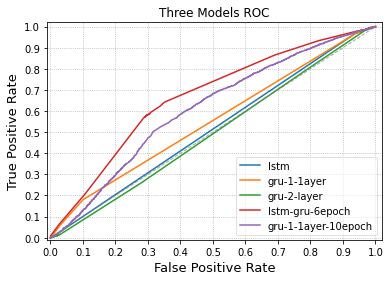

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
method=['lstm','gru-1-1ayer','gru-2-layer','lstm-gru-6epoch','gru-1-1ayer-10epoch']
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=method[i])
plt.title('Three Models ROC')
plt.legend(loc='lower right', fancybox=True, framealpha=0.6, fontsize=10)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')

### ROC curive model good order :  'gru-1-1ayer-10epoch' > 'lstm-gru-6epoch' > 'gru-1-1ayer' > 'lstm' > 'gru-2-layer'

In [79]:
method=['lstm','gru-1-1ayer','gru-2-layer','lstm-gru-6epoch','gru-1-1ayer-10epoch']
for i in range(5):
    print(method[i])
    print(auc[i])

lstm
0.5134716547294015
gru-1-1ayer
0.5505603014536362
gru-2-layer
0.49467113629859916
lstm-gru-6epoch
0.6664090863641936
gru-1-1ayer-10epoch
0.6095178796777359


### auc model good order : 'lstm-gru-6epoch' > 'gru-1-1ayer-10epoch' >  'gru-1-1ayer' > 'lstm' > 'gru-2-layer'